Loading dataset...
Loading pre-trained model and processor...
Preprocessing the image...
Compiling the model with torch.compile...
Measuring inference time for normal model...
Measuring inference time for compiled model...
Performing predictions...

Results:
Normal Model Prediction: tiger cat (Inference Time: 210.15 ms)
Compiled Model Prediction: tiger cat (Inference Time: 202.53 ms)

Model Sizes (KB):
Normal Model: 100166.96 KB
Compiled Model: 100173.53 KB
Size Reduction: -0.01%


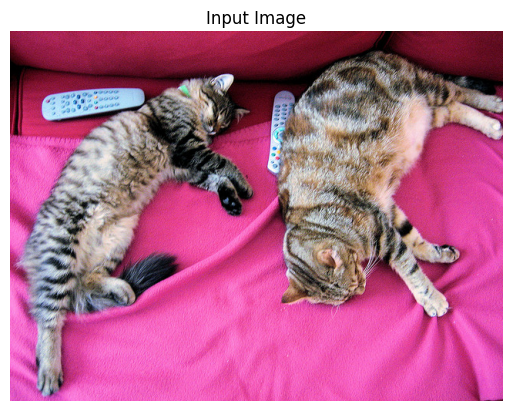

In [3]:
# Install required libraries
!pip install transformers datasets pillow -q

import torch
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
import time
import os

# Step 1: Load Dataset
print("Loading dataset...")
dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

# Step 2: Load Pretrained Model and Processor
print("Loading pre-trained model and processor...")
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# Step 3: Preprocess the Image
print("Preprocessing the image...")
inputs = processor(image, return_tensors="pt")

# Step 4: Compile the Model with torch.compile
print("Compiling the model with torch.compile...")
compiled_model = torch.compile(model)

# Step 5: Perform Inference with Normal and Compiled Models
def measure_inference_time(model, inputs, warmup_runs=5, measure_runs=10):
    """Measures the average inference time after warm-up runs."""
    # Warm-up runs
    for _ in range(warmup_runs):
        _ = model(**inputs).logits

    # Measure inference time
    total_time = 0
    for _ in range(measure_runs):
        start_time = time.time()
        _ = model(**inputs).logits
        total_time += (time.time() - start_time) * 1000  # Convert to ms

    avg_time = total_time / measure_runs
    return avg_time

# Measure inference time for normal model
print("Measuring inference time for normal model...")
normal_inference_time = measure_inference_time(model, inputs)

# Measure inference time for compiled model
print("Measuring inference time for compiled model...")
compiled_inference_time = measure_inference_time(compiled_model, inputs)

# Step 6: Perform Prediction
print("Performing predictions...")
with torch.no_grad():
    logits_normal = model(**inputs).logits
    logits_compiled = compiled_model(**inputs).logits

predicted_label_normal = logits_normal.argmax(-1).item()
predicted_label_compiled = logits_compiled.argmax(-1).item()

# Step 7: Save Models and Measure Sizes
normal_model_path = "resnet50_normal.pth"
compiled_model_path = "resnet50_compiled.pth"
torch.save(model.state_dict(), normal_model_path)
torch.save(compiled_model.state_dict(), compiled_model_path)

normal_model_size = os.path.getsize(normal_model_path) / 1024  # in KB
compiled_model_size = os.path.getsize(compiled_model_path) / 1024  # in KB

# Display results
print("\nResults:")
print(f"Normal Model Prediction: {model.config.id2label[predicted_label_normal]} (Inference Time: {normal_inference_time:.2f} ms)")
print(f"Compiled Model Prediction: {model.config.id2label[predicted_label_compiled]} (Inference Time: {compiled_inference_time:.2f} ms)")
print(f"\nModel Sizes (KB):")
print(f"Normal Model: {normal_model_size:.2f} KB")
print(f"Compiled Model: {compiled_model_size:.2f} KB")
print(f"Size Reduction: {((normal_model_size - compiled_model_size) / normal_model_size) * 100:.2f}%")

# Step 8: Display the Image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()
